## * Import Data Into Project * ##

In [5]:
# Import libraries
import os
import cv2
import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
from keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
from utils import import_train, import_others, view_train_images


In [6]:
# paths for data
train_dir = "C:/Users/RoiMinuit/Desktop/data/ILSVRC/Data/CLS-LOC/train"
test_dir = "C:/Users/RoiMinuit/Desktop/data/ILSVRC/Data/CLS-LOC/val"
val_dir = "C:/Users/RoiMinuit/Desktop/data/ILSVRC/Data/CLS-LOC/test"
labels_dir = "C:/Users/RoiMinuit/Desktop/data/ILSVRC/Data/Labels/imagenet_class_index.csv"


In [ ]:
# import images
train_images, train_labels = import_train(train_dir, 35000)
test_images = import_others(test_dir, 4750)
val_images = import_others(val_dir, 4750)


Images processed: 8750 (25%)
Images processed: 17500 (50%)
Images processed: 26250 (75%)
Function processed C:/Users/RoiMinuit/Desktop/data/ILSVRC/Data/CLS-LOC/train in 240 seconds.

Images processed: 2375 (50%)
Function processed C:/Users/RoiMinuit/Desktop/data/ILSVRC/Data/CLS-LOC/val in 34 seconds.

Images processed: 2375 (50%)
Function processed C:/Users/RoiMinuit/Desktop/data/ILSVRC/Data/CLS-LOC/test in 49 seconds.



## * Inspect Images * ##

In [ ]:
# view train images
view_train_images(train_images, train_labels)

In [ ]:
# check the shape of images
for i in range(0, 5):
    print(train_images[i].shape)

NameError: name 'train_images' is not defined

## 1) Edge Detection ##

In [ ]:
# define edge detection function

def edge_detection(image_arr, low_threshold = 100, high_threshold = 200):
    """ Detect edges in an image """
    # remove single channel dimension
    image_arr = image_arr.squeeze()
    # convert to uint8
    if image_arr.dtype != np.uint8:
        image_arr = (image_arr * 255).astype(np.uint8)
    # detect edges
    edges = cv2.Canny(image_arr, low_threshold, high_threshold)
    return edges

In [ ]:
# perform edge detection on images
train_edge_images = [edge_detection(image) for image in train_images]

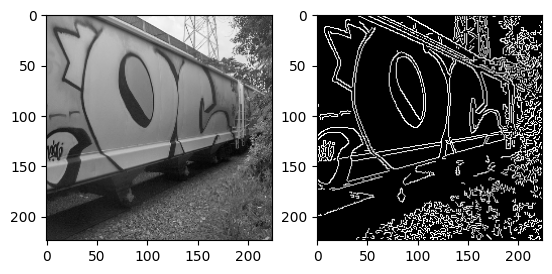

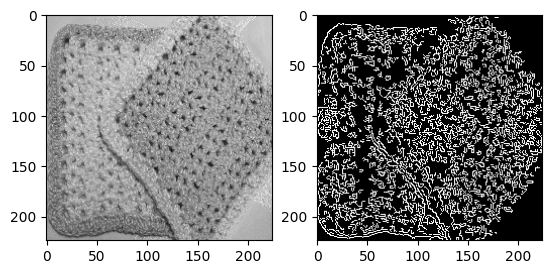

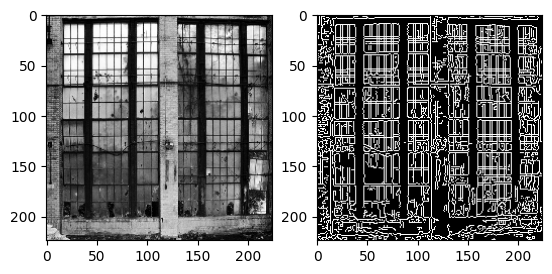

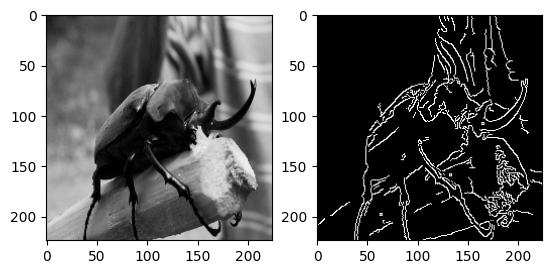

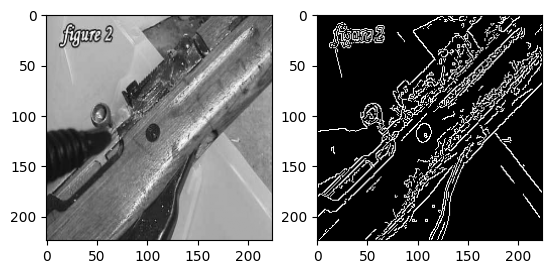

In [ ]:
# view edged image
def view_edged_image(image_arrays, image_edge, n):
    """ View an image array """
    for i in range(0, n):
        plt.subplot(1, 2, 1)
        plt.imshow(image_arrays[i], cmap='gray')
        plt.subplot(1, 2, 2)
        plt.imshow(image_edge[i], cmap='gray')
        plt.show()

view_edged_image(train_images, train_edge_images, 5)

## 2) Machine Learning ##

In [ ]:
# build a convolutional neural network (CNN) model
CNN = keras.Sequential([
        
])